In [1]:
import scanpy as sc
import numpy as np
import anndata2ri as ad

In [2]:
# Activate the anndata2ri conversion between SingleCellExperiment and AnnData
ad.activate()

#Loading the rpy2 extension enables cell magic to be used
#This runs R code in jupyter notebook cells
%load_ext rpy2.ipython

sc.settings.verbosity = 3
sc.logging.print_versions()

scanpy==1.5.1 anndata==0.7.3 umap==0.4.4 numpy==1.18.2 scipy==1.4.1 pandas==1.0.3 scikit-learn==0.22.2.post1 statsmodels==0.11.1 python-igraph==0.7.1 louvain==0.6.1 leidenalg==0.7.0


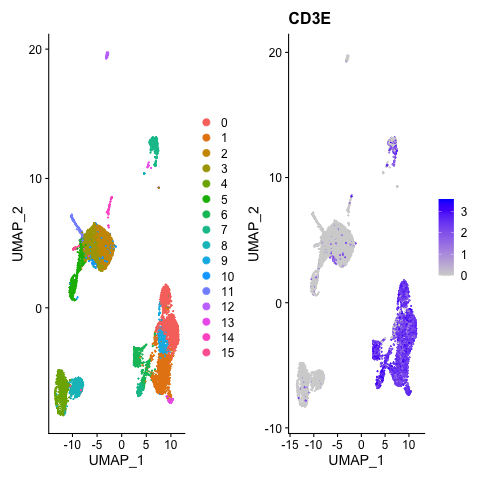

In [3]:
%%R

# IMPORTANT! Use Seurat v3.0.2 as subsequent versions are packaged with "Reticulate" which interferes with rpy2
library('Seurat') 
library('base')
library('patchwork')

#read your Seurat object in
V1 <- readRDS('../conga_datasets/processed/vdj_v1_hs_V1_sc_5gex.rds')

DimPlot(V1) | FeaturePlot( V1, "CD3E")
# Keep in mind, conga will keep only the T cells with paired TCR information

In [4]:
%%R -o V1_sce
# R-magics line above tells anndata2ri to convert the dataset to AnnData

#  but first convert your object to SingleCellExperiment Format 
V1_sce <- as.SingleCellExperiment(V1)
V1_sce

class: SingleCellExperiment 
dim: 33694 7726 
metadata(0):
assays(2): X logcounts
rownames(33694): RP11-34P13.3 FAM138A ... AC213203.1 FAM231B
rowData names(5): vst.mean vst.variance vst.variance.expected
  vst.variance.standardized vst.variable
colnames(7726): AAACCTGAGCGATAGC-1 AAACCTGAGCTAAACA-1 ...
  TTTGTCATCTTACCGC-1 TTTGTCATCTTGTTTG-1
colData names(6): orig.ident nCount_RNA ... seurat_clusters ident
reducedDimNames(2): PCA UMAP
altExpNames(0):


In [5]:
#write to h5ad for now. Ideally be nice to get away from strictly using the path
V1_sce.write("../conga_datasets/processed/vdj_v1_hs_V1_sc_5gex.h5ad")

In [6]:
%matplotlib inline

#begin conga workflow
import conga
import pandas as pd
import matplotlib.pyplot as plt
from conga.tcrdist.make_10x_clones_file import make_10x_clones_file

In [7]:
# call the Anndata file and conga on
gex_datafile = "../conga_datasets/processed/vdj_v1_hs_V1_sc_5gex.h5ad"
gex_datatype = 'h5ad' # other possibilities right now: ['10x_mtx', 'h5ad'] (h5ad from scanpy)
tcr_datafile = './testDrive/vdj_v1_hs_pbmc_t_filtered_contig_annotations.csv'
organism = 'human'
clones_file = 'tmp_hs_pbmc_clones.tsv'
outfile_prefix = 'tmp_hs_pbmc'

In [8]:
# this creates the TCRdist 'clones file'
make_10x_clones_file( tcr_datafile, organism, clones_file )

ab_counts: [((1, 1), 2138), ((2, 1), 169), ((1, 2), 77), ((2, 2), 11), ((3, 3), 1), ((4, 2), 1), ((1, 3), 1), ((3, 2), 1)]
old_num_barcodes: 2422 new_num_barcodes: 2307


In [9]:
# this command will create another file with the kernel PCs for subsequent reading by conga
conga.preprocess.make_tcrdist_kernel_pcs_file_from_clones_file( clones_file, organism )

compute tcrdist distance matrix for 2144 clonotypes
running KernelPCA (2144, 2144)
writing TCRdist kernel PCs to outfile: tmp_hs_pbmc_clones_AB.dist_50_kpcs


In [10]:
adata = conga.preprocess.read_dataset(gex_datafile, gex_datatype, clones_file )

# store the organism info in adata
adata.uns['organism'] = organism

adata

reading: ../conga_datasets/processed/vdj_v1_hs_V1_sc_5gex.h5ad of type h5ad
total barcodes: 7726 (7726, 33694)
reading: tmp_hs_pbmc_clones.tsv
reading: tmp_hs_pbmc_clones_AB.dist_50_kpcs
Reducing to the 2287 barcodes (out of 7726) with paired TCR sequence data


/Users/sschattg/conga-master/conga/preprocess.py:182: DeprecationWarning: Use is_view instead of isview, isview will be removed in the future.
  if adata.isview: # this is so weird
/Users/sschattg/conga-master/conga/preprocess.py:185: DeprecationWarning: Use is_view instead of isview, isview will be removed in the future.
  assert not adata.isview
/Users/sschattg/conga-master/conga/preprocess.py:259: DeprecationWarning: Use is_view instead of isview, isview will be removed in the future.
  assert not adata.isview
/Users/sschattg/conga-master/conga/preprocess.py:262: DeprecationWarning: Use is_view instead of isview, isview will be removed in the future.
  assert not adata.isview


AnnData object with n_obs × n_vars = 2287 × 33694
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'RNA_snn_res.0.8', 'seurat_clusters', 'ident', 'va', 'ja', 'cdr3a', 'cdr3a_nucseq', 'vb', 'jb', 'cdr3b', 'cdr3b_nucseq'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable'
    uns: 'organism'
    obsm: 'X_pca', 'X_umap', 'X_pca_tcr'
    layers: 'logcounts'

In [11]:
# top 50 TCRdist kPCS 
adata.obsm['X_pca_tcr'].shape

(2287, 50)

In [12]:
# CDR3-alpha regions:
adata.obs['cdr3a'].head(3)

AAACCTGAGTCTTGCA-1       CAQSDSNYQLIW
AAACCTGCAGATGGGT-1         CAVLTNDMRF
AAACCTGTCCTTGCCA-1    CATDFNTGANSKLTF
Name: cdr3a, dtype: object

In [13]:
adata = conga.preprocess.filter_and_scale( adata )

filtered out 18178 genes that are detected in less than 3 cells


/Users/sschattg/conga-master/conga/preprocess.py:304: DeprecationWarning: Use is_view instead of isview, isview will be removed in the future.
  assert not adata.isview
/Users/sschattg/conga-master/conga/preprocess.py:306: DeprecationWarning: Use is_view instead of isview, isview will be removed in the future.
  assert not adata.isview
/Users/sschattg/conga-master/conga/preprocess.py:318: DeprecationWarning: Use is_view instead of isview, isview will be removed in the future.
  assert not adata.isview


filtered out 643 cells with more than 2000 genes
filtered out 14 cells with more than 0.1 percent mito
unable to find feature_types varname
Index(['FO538757.2', 'AP006222.2', 'RP4-669L17.10', 'RP5-857K21.4',
       'RP11-206L10.9', 'LINC00115', 'NOC2L', 'KLHL17', 'PLEKHN1', 'HES4',
       ...
       'MT-ND6', 'MT-CYB', 'AC145212.4', 'AC145212.2', 'AC011043.1',
       'AL592183.1', 'AL354822.1', 'AC004556.1', 'AC233755.1', 'AC240274.1'],
      dtype='object', length=15516)
normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
extracting highly variable genes


/Users/sschattg/conga-master/conga/preprocess.py:320: DeprecationWarning: Use is_view instead of isview, isview will be removed in the future.
  assert not adata.isview
/Users/sschattg/conga-master/conga/preprocess.py:324: DeprecationWarning: Use is_view instead of isview, isview will be removed in the future.
  assert not adata.isview


    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
excluding 115 TR genes (89 variable)
excluding 1 sexlinked genes
total of 1324 variable genes (1630, 15516)
regressing out ['n_counts', 'percent_mito']
    sparse input is densified and may lead to high memory use


... storing 'va' as categorical
... storing 'ja' as categorical
... storing 'cdr3a' as categorical
... storing 'cdr3a_nucseq' as categorical
... storing 'vb' as categorical
... storing 'jb' as categorical
... storing 'cdr3b' as categorical
... storing 'cdr3b_nucseq' as categorical
/Users/sschattg/.local/lib/python3.8/site-packages/patsy/constraint.py:13: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.9 it will stop working
  from collections import Mapping


    finished (0:00:03)


In [14]:
adata = conga.preprocess.reduce_to_single_cell_per_clone( adata )

adata

compute pca to find rep cell for each clone (1630, 1324)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)
num_clones: 1539
Normalize and logging matrix...
unable to find feature_types varname
Index(['HES4', 'TNFRSF4', 'RP3-395M20.12', 'MEGF6', 'ACOT7', 'RP1-202O8.3',
       'RP11-312B8.1', 'UTS2', 'TNFRSF9', 'SPSB1',
       ...
       'PKNOX1', 'AP001055.6', 'ITGB2', 'ITGB2-AS1', 'COL18A1', 'COL6A1',
       'COL6A2', 'C21orf58', 'S100B', 'MT-ND6'],
      dtype='object', length=1324)
found 489 of 512 good_genes in var_names  organism=human
reduce from 1630 cells to 1539 cells (one per clonotype)
normalize_and_log_the_raw_matrix:: matrix is already logged


AnnData object with n_obs × n_vars = 1539 × 1324
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'RNA_snn_res.0.8', 'seurat_clusters', 'ident', 'va', 'ja', 'cdr3a', 'cdr3a_nucseq', 'vb', 'jb', 'cdr3b', 'cdr3b_nucseq', 'n_genes', 'percent_mito', 'n_counts', 'clone_sizes'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'organism', 'log1p', 'pca', 'raw_matrix_is_logged', 'X_igex_genes'
    obsm: 'X_umap', 'X_pca_tcr', 'X_igex'
    varm: 'PCs'
    layers: 'logcounts'

In [15]:
adata = conga.preprocess.cluster_and_tsne_and_umap( adata )

adata

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 40


/Users/sschattg/opt/anaconda3/envs/conga_env/lib/python3.8/site-packages/numba/np/ufunc/parallel.py:355: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 11000. The TBB threading layer is disabled.
  warnings.warn(problem)


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:02)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 8 clusters and added
    'louvain_gex', the cluster labels (adata.obs, categorical) (0:00:00)
ran louvain clustering: louvain_gex
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:02)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 10 clusters and added
    'louvain_tcr', the cluster labels (adata.obs, categorical) (0:00:00)
ran lou

AnnData object with n_obs × n_vars = 1539 × 1324
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'RNA_snn_res.0.8', 'seurat_clusters', 'ident', 'va', 'ja', 'cdr3a', 'cdr3a_nucseq', 'vb', 'jb', 'cdr3b', 'cdr3b_nucseq', 'n_genes', 'percent_mito', 'n_counts', 'clone_sizes', 'louvain_gex', 'clusters_gex', 'louvain_tcr', 'clusters_tcr'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'organism', 'log1p', 'pca', 'raw_matrix_is_logged', 'X_igex_genes', 'neighbors', 'umap', 'louvain'
    obsm: 'X_pca_tcr', 'X_igex', 'X_pca_gex', 'X_umap_gex', 'X_gex_2d', 'X_umap_tcr', 'X_tcr_2d'
    varm: 'PCs'
    layers: 'logcounts'
    obsp: 'distances', 'connectivities'

In [16]:
plt.figure(figsize=(12,6))
plt.subplot(121)
xy = adata.obsm['X_gex_2d']
clusters = np.array(adata.obs['clusters_gex'])
cmap = plt.get_cmap('tab20')
colors = [ cmap.colors[x] for x in clusters]
plt.scatter( xy[:,0], xy[:,1], c=colors)
plt.title('GEX UMAP colored by GEX clusters')

plt.subplot(122)
xy = adata.obsm['X_tcr_2d']
clusters = np.array(adata.obs['clusters_tcr'])
cmap = plt.get_cmap('tab20')
colors = [ cmap.colors[x] for x in clusters]
plt.scatter( xy[:,0], xy[:,1], c=colors)
plt.title('TCR UMAP colored by TCR clusters');

compute D_gex 1539
compute D_tcr 1539
argpartitions: 0.01 1539
calculate nndists: 0.01
DONE calculating nndists: 0.01
argpartitions: 0.1 1539
setup_tcr_cluster_names: ['0', '1_AV8', '2', '3_AV14++', '4', '5_BV20', '6_AV12', '7_AV26', '8_AV1', '9_AV9']


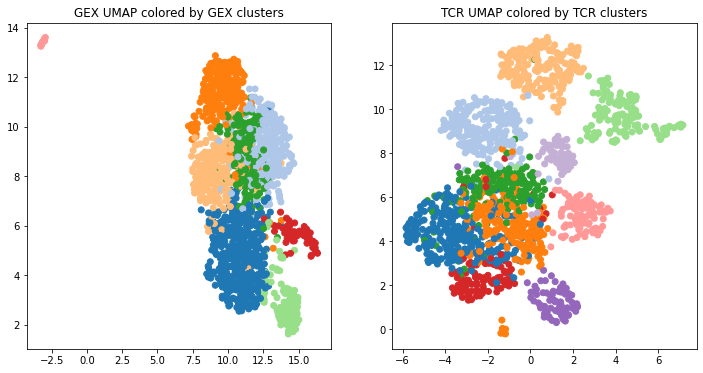

In [17]:
# these are the nbrhood sizes, as a fraction of the entire dataset:
nbr_fracs = [0.01, 0.1]

# we use this nbrhood size for computing the nndists
nbr_frac_for_nndists = 0.01

all_nbrs, nndists_gex, nndists_tcr = conga.preprocess.calc_nbrs(
    adata, nbr_fracs, also_calc_nndists=True, nbr_frac_for_nndists=nbr_frac_for_nndists)

# stash these in obs array, they are used in a few places...                                                                                                                
adata.obs['nndists_gex'] = nndists_gex
adata.obs['nndists_tcr'] = nndists_tcr

conga.preprocess.setup_tcr_cluster_names(adata) #stores in adata.uns

In [18]:
results = conga.correlations.run_graph_vs_graph(adata, all_nbrs)

conga_scores = adata.obs['conga_scores']

good_mask = ( conga_scores <= 1.0 )
adata.obs['good_score_mask'] = good_mask

print(f'found {np.sum(good_mask)} conga hits')

results.sort_values('conga_score', inplace=True)

results.head(3)

find_neighbor_neighbor_interactions:
find_neighbor_cluster_interactions:
find_neighbor_cluster_interactions:
find_neighbor_neighbor_interactions:
find_neighbor_cluster_interactions:
find_neighbor_cluster_interactions:
found 100 conga hits


,conga_score,num_neighbors_gex,num_neighbors_tcr,overlap,overlap_corrected,mait_fraction,clone_index,nbr_frac,overlap_type,num_neighbors,cluster_size
248,5.722190e-49,NaN,NaN,72,59,0.888889,103,0.1,cluster_nbr,153.0,110.0
229,1.738370e-47,NaN,NaN,71,58,0.887324,77,0.1,cluster_nbr,153.0,110.0
209,1.738370e-47,NaN,NaN,71,58,0.887324,52,0.1,cluster_nbr,153.0,110.0


In [19]:
# write the results to a tsv file
clusters_gex = np.array(adata.obs['clusters_gex'])
clusters_tcr = np.array(adata.obs['clusters_tcr'])

indices = results['clone_index']
results['gex_cluster'] = clusters_gex[indices]
results['tcr_cluster'] = clusters_tcr[indices]
for tag in 'va ja cdr3a vb jb cdr3b'.split():
    results[tag] = list(adata.obs[tag][indices])
tsvfile = outfile_prefix+'_graph_vs_graph_hits.tsv'
print('saving graph-vs-graph results to file:',tsvfile)

results.to_csv(tsvfile, sep='\t', index=False)

saving graph-vs-graph results to file: tmp_hs_pbmc_graph_vs_graph_hits.tsv


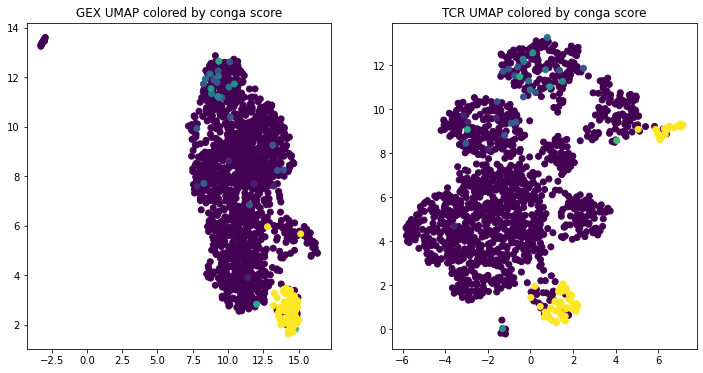

In [20]:
#put the conga hits on top
colors = np.sqrt(np.maximum(-1*np.log10(conga_scores),0.0))
reorder = np.argsort(colors)

plt.figure(figsize=(12,6))
plt.subplot(121)
xy = adata.obsm['X_gex_2d']
plt.scatter( xy[reorder,0], xy[reorder,1], c=colors[reorder], vmin=0, vmax=np.sqrt(5))
plt.title('GEX UMAP colored by conga score')

plt.subplot(122)
xy = adata.obsm['X_tcr_2d']
plt.scatter( xy[reorder,0], xy[reorder,1], c=colors[reorder], vmin=0, vmax=np.sqrt(5))
plt.title('TCR UMAP colored by conga score');

[((5, 8), 47), ((5, 5), 22), ((2, 3), 18), ((1, 1), 4), ((0, 1), 3), ((3, 1), 2), ((6, 8), 1), ((5, 2), 1), ((3, 0), 1), ((4, 1), 1)]
making tcr score table: ['alphadist', 'cd8', 'cdr3len', 'mhci2', 'mait', 'inkt', 'nndists_tcr', 'af1', 'af2', 'af3', 'af4', 'af5', 'alpha', 'beta', 'charge', 'core', 'disorder', 'hydropathy', 'kf1', 'kf10', 'kf2', 'kf3', 'kf4', 'kf5', 'kf6', 'kf7', 'kf8', 'kf9', 'mjenergy', 'polarity', 'rim', 'strength', 'surface', 'turn', 'volume']
[((5, 8), 47), ((5, 5), 22), ((2, 3), 18), ((1, 1), 4), ((0, 1), 3), ((3, 1), 2), ((6, 8), 1), ((5, 2), 1), ((3, 0), 1), ((4, 1), 1)]
run rank_genes_groups [('none', 1452), ('clp_5_8', 47), ('clp_5_5', 22), ('clp_2_3', 18)]
ranking genes


... storing 'test' as categorical


    finished: added to `.uns['rank_genes_good_biclusters']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:01)
clp: 0 3 tmp_hs_pbmc_bicluster_logos.png
clp: 1 3 tmp_hs_pbmc_bicluster_logos.png
clp: 2 3 tmp_hs_pbmc_bicluster_logos.png


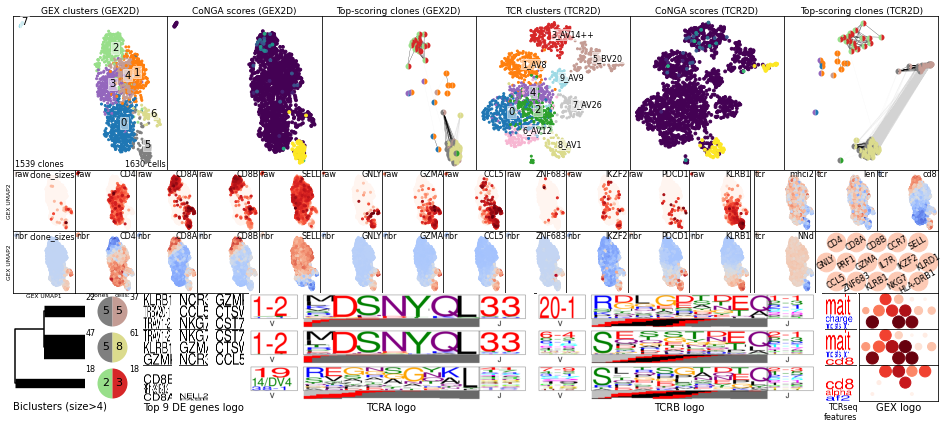

In [21]:
nbrs_gex, nbrs_tcr = all_nbrs[0.1]

min_cluster_size = 5

# calc tcr sequence features of good cluster pairs
good_bicluster_tcr_scores = conga.correlations.calc_good_cluster_tcr_features(
    adata, good_mask, clusters_gex, clusters_tcr, conga.tcr_scoring.all_tcr_scorenames, verbose=False,
    min_count=min_cluster_size)

# run rank_genes on most common biclusters
rank_genes_uns_tag = 'rank_genes_good_biclusters'
conga.correlations.run_rank_genes_on_good_biclusters(
    adata, good_mask, clusters_gex, clusters_tcr, min_count=min_cluster_size, key_added= rank_genes_uns_tag)

gex_header_tcr_score_names = ['mhci2', 'cdr3len', 'cd8', 'nndists_tcr']

logo_pngfile = outfile_prefix+'_bicluster_logos.png'

conga.plotting.make_logo_plots(
    adata, nbrs_gex, nbrs_tcr, min_cluster_size, logo_pngfile,
    good_bicluster_tcr_scores=good_bicluster_tcr_scores,
    rank_genes_uns_tag = rank_genes_uns_tag,
    gex_header_tcr_score_names = gex_header_tcr_score_names )

finding biased GEX features for nbrhoods with size 0.01 (1539, 15)
finding biased GEX features for nbrhoods with size 0.1 (1539, 153)
making: tmp_hs_pbmc_tcr_nbr_graph_vs_gex_features.tsv
making: tmp_hs_pbmc_tcr_nbr_graph_vs_gex_features.png


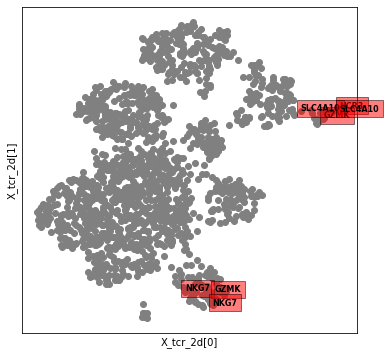

In [22]:
pval_threshold = 1.
results = []
for nbr_frac in nbr_fracs:
    nbrs_gex, nbrs_tcr = all_nbrs[nbr_frac]
    print('finding biased GEX features for nbrhoods with size', nbr_frac, nbrs_gex.shape)
    results.append( conga.correlations.tcr_nbrhood_rank_genes_fast( adata, nbrs_tcr, pval_threshold, verbose=False))
    results[-1]['nbr_frac'] = nbr_frac

# save the results to a file
tsvfile = outfile_prefix+'_tcr_nbr_graph_vs_gex_features.tsv'
print('making:', tsvfile)
results_df = pd.concat(results, ignore_index=True)
results_df.to_csv(tsvfile, index=False, sep='\t')

pngfile = outfile_prefix+'_tcr_nbr_graph_vs_gex_features.png'
print('making:', pngfile)
conga.plotting.plot_ranked_strings_on_cells(
    adata, results_df, 'X_tcr_2d', 'clone_index', 'mwu_pvalue_adj', 1.0, 'feature', pngfile)

making: tmp_hs_pbmc_tcr_nbr_graph_vs_gex_features_panels.png
SLC4A10
KLRB1
GZMK
CST7
NKG7
NCR3


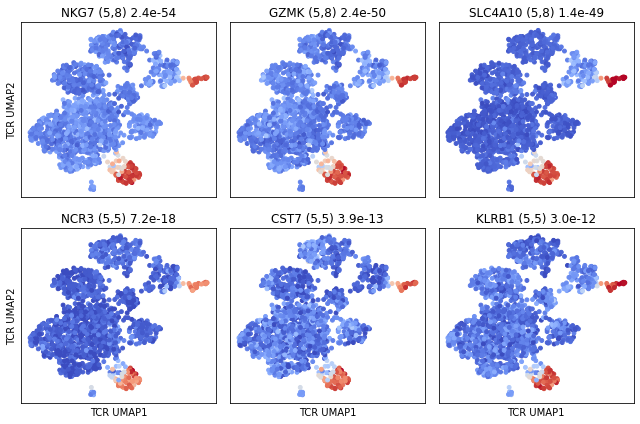

In [23]:
pngfile = outfile_prefix+'_tcr_nbr_graph_vs_gex_features_panels.png'
print('making:', pngfile)
conga.plotting.make_feature_panel_plots(adata, 'tcr', all_nbrs, results_df, pngfile)

making tcr score table: ['alphadist', 'cd8', 'cdr3len', 'mhci2', 'mait', 'inkt', 'nndists_tcr', 'af1', 'af2', 'af3', 'af4', 'af5', 'alpha', 'beta', 'charge', 'core', 'disorder', 'hydropathy', 'kf1', 'kf10', 'kf2', 'kf3', 'kf4', 'kf5', 'kf6', 'kf7', 'kf8', 'kf9', 'mjenergy', 'polarity', 'rim', 'strength', 'surface', 'turn', 'volume']
making tcr score table: ['alphadist', 'cd8', 'cdr3len', 'mhci2', 'mait', 'inkt', 'nndists_tcr', 'af1', 'af2', 'af3', 'af4', 'af5', 'alpha', 'beta', 'charge', 'core', 'disorder', 'hydropathy', 'kf1', 'kf10', 'kf2', 'kf3', 'kf4', 'kf5', 'kf6', 'kf7', 'kf8', 'kf9', 'mjenergy', 'polarity', 'rim', 'strength', 'surface', 'turn', 'volume']
making: tmp_hs_pbmc_gex_nbr_graph_vs_tcr_features.tsv
making: tmp_hs_pbmc_gex_nbr_graph_vs_tcr_features.png


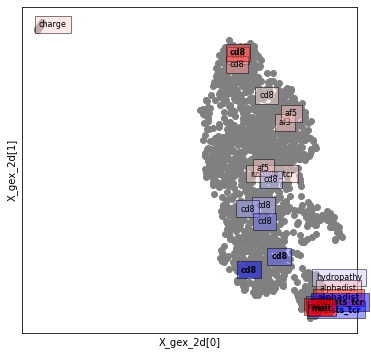

In [24]:
pval_threshold = 1.
results = []
tcr_score_names = conga.tcr_scoring.all_tcr_scorenames # the TCR features to use
for nbr_frac in nbr_fracs:
    nbrs_gex, nbrs_tcr = all_nbrs[nbr_frac]
    results.append( conga.correlations.gex_nbrhood_rank_tcr_scores(
        adata, nbrs_gex, tcr_score_names, pval_threshold, verbose=False ))
    results[-1]['nbr_frac'] = nbr_frac
results_df = pd.concat(results, ignore_index=True)

tsvfile = outfile_prefix+'_gex_nbr_graph_vs_tcr_features.tsv'
print('making:', tsvfile)
results_df.to_csv(tsvfile, index=False, sep='\t')

pngfile = outfile_prefix+'_gex_nbr_graph_vs_tcr_features.png'
print('making:', pngfile)

conga.plotting.plot_ranked_strings_on_cells(
    adata, results_df, 'X_gex_2d', 'clone_index', 'mwu_pvalue_adj', 1.0, 'feature', pngfile,
    direction_column='ttest_stat')

making: tmp_hs_pbmc_gex_nbr_graph_vs_tcr_features_panels.png
alphadist
nndists_tcr
polarity
charge
cd8
mait
kf7


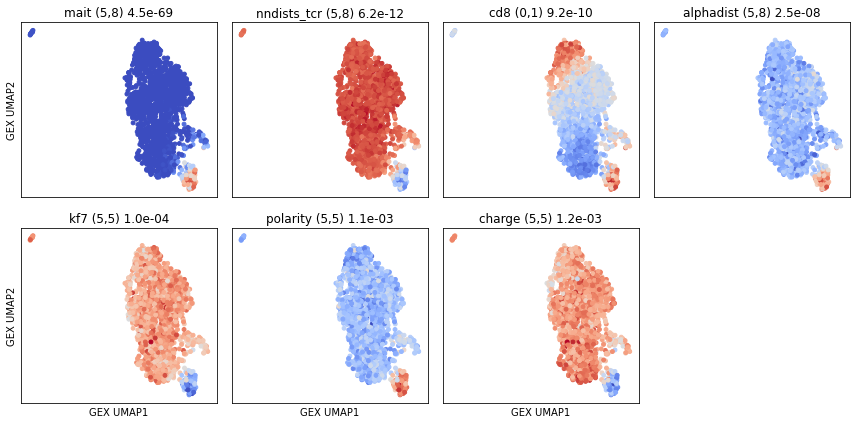

In [25]:
pngfile = outfile_prefix+'_gex_nbr_graph_vs_tcr_features_panels.png'
print('making:', pngfile)
conga.plotting.make_feature_panel_plots(adata, 'gex', all_nbrs, results_df, pngfile)